Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

Ariel Solís Monge B97664

## Imports and config

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import wandb
import config


In [2]:
wandb.login(key=config.API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dlizano (ci-0148-g3). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Israel\_netrc


True

In [3]:
if config.USE_UNET: import unet as autoencoder
else: import convolutional_autoencoder as autoencoder

In [4]:
labeled_train_relative_set_size = round((config.LABELED_TRAIN_SET_ABSOLUTE_SIZE / (1 - config.UNLABELED_SET_SIZE)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

In [5]:
# Set up of the device
if torch.backends.mps.is_available():
    device = torch.device("mps")#tqm
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## Datasets and dataloaders

In [6]:
data_transforms = {
    'bce': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'mse': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4641, 0.4891, 0.4096], [0.1883, 0.1621, 0.2068])
    ])
}

In [7]:
full_dataset = datasets.ImageFolder(config.BASE_DIR_RAW, transform=data_transforms[config.AE_TRANSFORMS])
full_noisy_dataset = datasets.ImageFolder(config.BASE_DIR_NOISY, transform=data_transforms[config.AE_TRANSFORMS])

In [8]:
indices = list(range(len(full_dataset)))
noisy_indices =list(range(len(full_noisy_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]
noisy_image_paths = [sample[0] for sample in full_noisy_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]
noisy_labels = [os.path.split(os.path.dirname(path))[-1] for path in noisy_image_paths]

In [9]:
#Obtenemos el 20% de los datos 
train_val_indices, _  = train_test_split(indices, test_size=config.UNLABELED_SET_SIZE, stratify=labels, random_state=42)#Obtenemos el 20% de los datos 
noisy_train_val_indices, _ = train_test_split(noisy_indices, test_size=config.UNLABELED_SET_SIZE, stratify=noisy_labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]
noisy_train_val_labels = [noisy_labels[i] for i in noisy_train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=labeled_test_relative_set_size, stratify=train_val_labels, random_state=42)
noisy_train_indices, noisy_val_indices = train_test_split(noisy_train_val_indices, test_size=labeled_test_relative_set_size, stratify=noisy_train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
noisy_train_dataset = Subset(full_noisy_dataset, noisy_train_indices)
val_dataset = Subset(full_dataset, val_indices)
noisy_val_dataset = Subset(full_dataset, noisy_val_indices)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
noisy_loader = DataLoader(noisy_train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
noisy_val_loader = DataLoader(noisy_val_dataset, batch_size=4, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de entrenamiento: {len(noisy_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(noisy_val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 21520
Número de imágenes en el conjunto de entrenamiento: 21520
Número de imágenes en el conjunto de validación: 9223
Número de imágenes en el conjunto de validación: 9223


## Function definitions

In [11]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [12]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    wandb_name = config.CNN_DENOISING_SAVE_PATH if config.USE_DENOISING_AUTOENCODER else config.CNN_ENCODER_SAVE_PATH

    wandb.init(project="classifier_training", name=wandb_name)    
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), config.CNN_ENCODER_SAVE_PATH)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [13]:
def evaluate_model(model, dataloader, device):
    wandb_name = config.CNN_DENOISING_SAVE_PATH if config.USE_DENOISING_AUTOENCODER else config.CNN_ENCODER_SAVE_PATH
    wandb.init(project="classifier_evaluation", name=wandb_name)

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    class_names = dataloader.dataset.dataset.classes
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f'Overall Accuracy: {accuracy:.4f}')
    print("\nMetrics by Class:")
    print("{:<20} {:<10} {:<10} {:<10}".format("Class", "Accuracy", "Precision", "Recall"))
    print("="*50)
    for class_name, class_accuracy, class_precision, class_recall in zip(class_names, class_accuracies, precision, recall):
        print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(class_name, class_accuracy, class_precision, class_recall))

    wandb.log({
        "overall_accuracy": accuracy,
        "confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=all_labels, preds=all_preds, class_names=class_names),
        "precision": {class_name: class_precision for class_name, class_precision in zip(class_names, precision)},
        "recall": {class_name: class_recall for class_name, class_recall in zip(class_names, recall)},
        "class_accuracies": {class_name: class_accuracy for class_name, class_accuracy in zip(class_names, class_accuracies)}
    })
    
    return accuracy

In [14]:
# Load the encoder model
def load_encoder(model_path, device):
    model = autoencoder.AutoEncoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    encoder = model.encoder
    encoder = encoder.to(device)
    return model, encoder

## Encoder + CNN Classifier

In [15]:
cnn_model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = config.LATENT_CHANNELS  # Change this to the desired number of input channels
original_conv1 = cnn_model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Inicializar los pesos de la nueva capa convolucional
with torch.no_grad():
    if new_in_channels == 1:
        # Promediar los pesos de la capa original a través de los canales de entrada
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Inicializar pesos promediando los pesos de los primeros dos canales
        new_conv1.weight[:, :2] = original_conv1.weight[:, :2].mean(dim=1, keepdim=True)
        if new_in_channels > 2:
            for i in range(2, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Reemplazar la primera capa convolucional en el modelo
cnn_model.features[0][0] = new_conv1
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self, encoder_model=None, cnn_model=None):
        super(EncoderCNN, self).__init__()
        self.encoder = encoder_model
        self.cnn = cnn_model
    

    def forward(self, x):
        x = self.encoder(x)
        if config.USE_UNET: x = x[4]
        x = x.reshape(x.shape[0], config.LATENT_CHANNELS, config.HEIGHT, config.WIDHT)
        output = self.cnn(x)
        return output

In [17]:
autoencoder, encoder_model = load_encoder(config.AUTOENCODER_SAVE_PATH, device)

In [18]:
model = EncoderCNN(encoder_model, cnn_model)
model = model.to(device)
model.encoder.requires_grad_(config.TRAIN_ENCODER_WEIGHTS)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.3)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.3)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

### Training

In [20]:
if not config.USE_DENOISING_AUTOENCODER:
    train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=config.EPOCHS, patience=config.PATIENCE)
else:
    train_model(model, criterion, optimizer, noisy_loader, noisy_val_loader, device, num_epochs=config.EPOCHS, patience=config.PATIENCE)

100%|██████████| 5380/5380 [02:21<00:00, 38.07it/s]


Epoch 1/30
Train Loss: 3.2796 Acc: 0.1702
Val Loss: 2.7803 Acc: 0.2225


100%|██████████| 5380/5380 [02:18<00:00, 38.73it/s]


Epoch 2/30
Train Loss: 2.6163 Acc: 0.2798
Val Loss: 2.0124 Acc: 0.4007


100%|██████████| 5380/5380 [02:12<00:00, 40.52it/s]


Epoch 3/30
Train Loss: 1.9107 Acc: 0.4402
Val Loss: 1.4197 Acc: 0.5760


100%|██████████| 5380/5380 [02:16<00:00, 39.51it/s]


Epoch 4/30
Train Loss: 1.4731 Acc: 0.5566
Val Loss: 1.1794 Acc: 0.6315


100%|██████████| 5380/5380 [02:16<00:00, 39.49it/s]


Epoch 5/30
Train Loss: 1.1891 Acc: 0.6357
Val Loss: 0.9249 Acc: 0.7114


100%|██████████| 5380/5380 [02:12<00:00, 40.74it/s]


Epoch 6/30
Train Loss: 1.0074 Acc: 0.6879
Val Loss: 0.8529 Acc: 0.7480


100%|██████████| 5380/5380 [02:15<00:00, 39.78it/s]


Epoch 7/30
Train Loss: 0.8627 Acc: 0.7350
Val Loss: 0.6131 Acc: 0.8101


100%|██████████| 5380/5380 [02:17<00:00, 39.21it/s]


Epoch 8/30
Train Loss: 0.7586 Acc: 0.7642
Val Loss: 0.7945 Acc: 0.7926


100%|██████████| 5380/5380 [02:15<00:00, 39.67it/s]


Epoch 9/30
Train Loss: 0.6954 Acc: 0.7861
Val Loss: 0.5494 Acc: 0.8334


100%|██████████| 5380/5380 [02:21<00:00, 37.91it/s]


Epoch 10/30
Train Loss: 0.5974 Acc: 0.8149
Val Loss: 0.5417 Acc: 0.8315


100%|██████████| 5380/5380 [02:17<00:00, 39.15it/s]


Epoch 11/30
Train Loss: 0.5580 Acc: 0.8252
Val Loss: 0.4716 Acc: 0.8530


100%|██████████| 5380/5380 [02:15<00:00, 39.57it/s]


Epoch 12/30
Train Loss: 0.5099 Acc: 0.8396
Val Loss: 0.4466 Acc: 0.8651


100%|██████████| 5380/5380 [02:16<00:00, 39.54it/s]


Epoch 13/30
Train Loss: 0.4688 Acc: 0.8523
Val Loss: 0.4390 Acc: 0.8683


100%|██████████| 5380/5380 [02:13<00:00, 40.23it/s]


Epoch 14/30
Train Loss: 0.4329 Acc: 0.8625
Val Loss: 0.4020 Acc: 0.8814


100%|██████████| 5380/5380 [02:16<00:00, 39.36it/s]


Epoch 15/30
Train Loss: 0.3984 Acc: 0.8744
Val Loss: 0.4300 Acc: 0.8696


100%|██████████| 5380/5380 [02:16<00:00, 39.32it/s]


Epoch 16/30
Train Loss: 0.3684 Acc: 0.8829
Val Loss: 0.4755 Acc: 0.8538


100%|██████████| 5380/5380 [02:17<00:00, 39.23it/s]


Epoch 17/30
Train Loss: 0.3437 Acc: 0.8908
Val Loss: 0.3130 Acc: 0.9037


100%|██████████| 5380/5380 [02:15<00:00, 39.66it/s]


Epoch 18/30
Train Loss: 0.3237 Acc: 0.8966
Val Loss: 0.3296 Acc: 0.8974


100%|██████████| 5380/5380 [02:15<00:00, 39.60it/s]


Epoch 19/30
Train Loss: 0.2972 Acc: 0.9044
Val Loss: 0.3556 Acc: 0.8970


100%|██████████| 5380/5380 [02:16<00:00, 39.39it/s]


Epoch 20/30
Train Loss: 0.2885 Acc: 0.9072
Val Loss: 0.4102 Acc: 0.8825


100%|██████████| 5380/5380 [02:16<00:00, 39.39it/s]


Epoch 21/30
Train Loss: 0.2741 Acc: 0.9102
Val Loss: 0.3626 Acc: 0.8971


100%|██████████| 5380/5380 [02:17<00:00, 39.23it/s]


Epoch 22/30
Train Loss: 0.2555 Acc: 0.9173
Val Loss: 0.3699 Acc: 0.8956
Early stopping triggered!


In [21]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda


### Evaluation

In [22]:
model = EncoderCNN(encoder_model, cnn_model)
model.load_state_dict(torch.load(config.CNN_ENCODER_SAVE_PATH, map_location=device))
model = model.to(device)

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_acc,▁▂▄▅▅▆▆▇▇▇▇▇▇▇████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▅▆▆▇▇▇▇▇████▇██████
val_loss,█▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
train_acc,0.91729
train_loss,0.25551
val_acc,0.89559
val_loss,0.36991


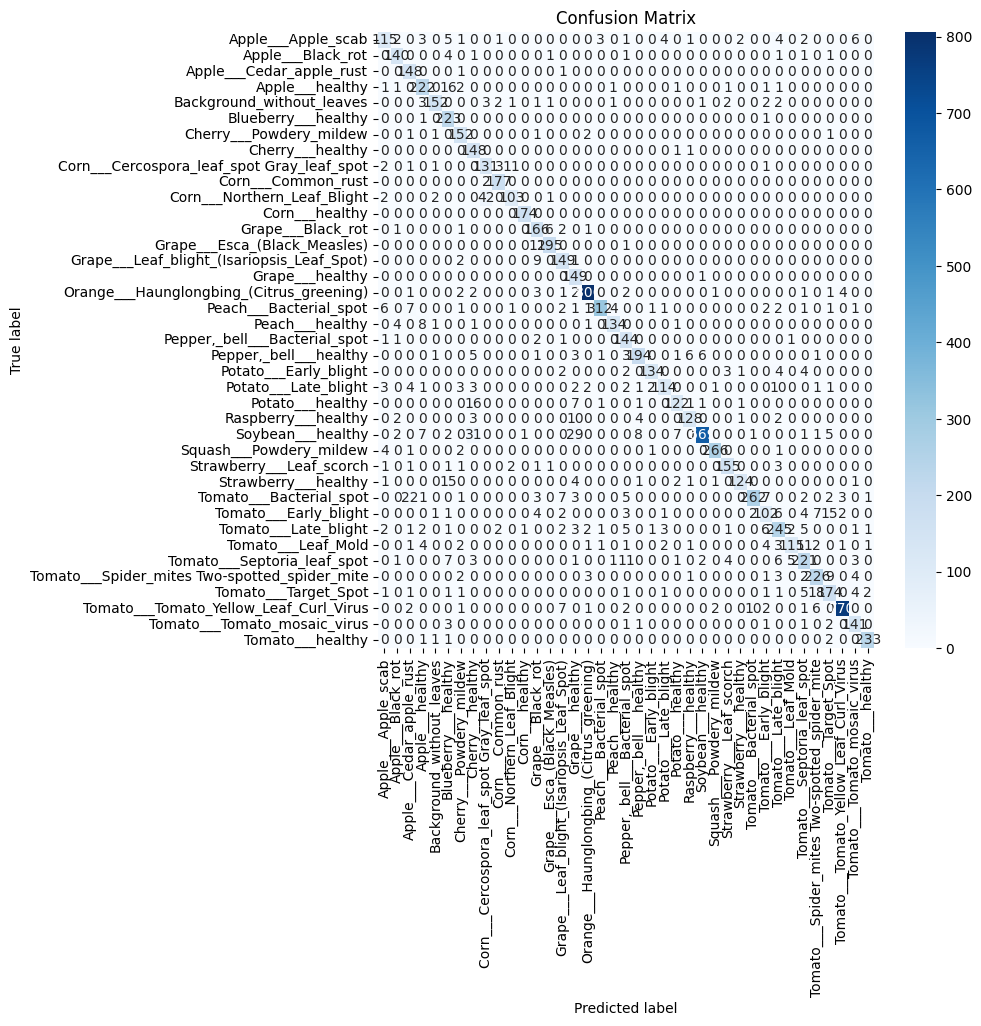

Overall Accuracy: 0.9037

Metrics by Class:
Class                Accuracy   Precision  Recall    
Apple___Apple_scab   0.7667     0.8273     0.7667    
Apple___Black_rot    0.9333     0.9091     0.9333    
Apple___Cedar_apple_rust 0.9867     0.7749     0.9867    
Apple___healthy      0.8988     0.8775     0.8988    
Background_without_leaves 0.8889     0.9500     0.8889    
Blueberry___healthy  0.9911     0.7964     0.9911    
Cherry___Powdery_mildew 0.9620     0.8686     0.9620    
Cherry___healthy     0.9867     0.6948     0.9867    
Corn___Cercospora_leaf_spot Gray_leaf_spot 0.8733     0.7360     0.8733    
Corn___Common_rust   0.9888     0.9568     0.9888    
Corn___Northern_Leaf_Blight 0.6867     0.8729     0.6867    
Corn___healthy       1.0000     0.9886     1.0000    
Grape___Black_rot    0.9379     0.8177     0.9379    
Grape___Esca_(Black_Measles) 0.9375     0.9512     0.9375    
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 0.9255     0.8466     0.9255    
Grape___healthy      

In [23]:
if not config.USE_DENOISING_AUTOENCODER:
    evaluate_model(model, val_loader, device)
else:
    evaluate_model(model, noisy_val_loader, device)